In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd /content/gdrive/My Drive/Colab Notebooks/Practice-ML/Grad_thesis/

/content/gdrive/My Drive/Colab Notebooks/Practice-ML/Grad_thesis


In [3]:
!pip install torch
!pip install torchvision
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install pillow
!pip install opencv-python

In [1]:
import os
import random
import copy
import argparse
import time
from statistics import mean, variance, stdev
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, transforms
import torch.utils.data as data
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.style
import torchvision.utils as vutils
from sklearn.model_selection import train_test_split

from seq_net import weights_init, Generator, Discriminator
import seq_modules as sem

In [2]:
# 設定
workers = 0
batch_size=32
nz = 100
nch_g = 128
nch_d = 128
n_epoch = 50
lr = 0.0002
beta1 = 0.5
outf = './Result/lsGAN'
display_interval = 100

# 保存先ディレクトリを作成
try:
    os.makedirs(outf, exist_ok=True)
except OSError as error: 
    print(error)
    pass

# 乱数のシード（種）を固定
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [3]:
SEQ_LENGTH = 128

def make_dataset(datadir):
    '''
    convert sequence to vector array
    1.init array all 0 (4*SEQ_LENGTH)
    2.convert sequences (all 0 array) to vector array.
    ex. ACCGAT =
    0 0 0 0 0 0    1 0 0 0 1 0
    0 0 0 0 0 0  → 0 1 1 0 0 0
    0 0 0 0 0 0    0 0 0 1 0 0
    0 0 0 0 0 0    0 0 0 0 0 1
    '''
    pos_seq = "SRX356455.05_peak_seq_128.txt"
    # id      chr     start   end     seq
    data = pd.read_csv(os.path.join(datadir, "sequences", pos_seq), sep="\t")
    sequences = [] 
    classes = [] #positive or negative
    for index, row in data[["id", "seq"]].iterrows():
        y = 1 #positive
        seq_vector = seq2vector(row["seq"])
        if len(seq_vector) == 0:
            continue
        sequences.append(seq2vector(row["seq"]))
        classes.append(np.array(y))
    return sequences, classes

def seq2vector(seq):
    if type(seq) is not str: # Case on Null sequence
        return np.zeros((0,0))
    seq_array = np.zeros((4, SEQ_LENGTH)) #initiallize 4*SEQ_LENGTH array all 0
    flag = 0
    for i in range(SEQ_LENGTH):
        s = seq[i]
        if s == "a" or s == "A":
            seq_array[0, i] = 1
        elif s == "c" or s == "C":
            seq_array[1, i] = 1
        elif s == "g" or s == "G":
            seq_array[2, i] = 1
        elif s == "t" or s == "T":
            seq_array[3, i] = 1
        else:
            flag += 1
    if len(seq) == flag: # Case on N sequence
        return np.zeros((0,0))
    seq_array = seq_array.astype(np.float32)
    return seq_array

In [4]:
datadir = "data"

class DatasetFolder(data.Dataset):
    def __init__(self, X, y):
        self.samples = X
        self.targets = y
        self.transforms = transforms.Compose([
            ToTensorOfTarget()
        ])

    def __getitem__(self, index):
        sample = self.samples[index]
        sample = self.transforms(sample)
        target = self.targets[index]
        target = self.transforms(target)
        return sample, target

    def __len__(self):
        return len(self.samples)


class ToTensorOfTarget(object):
    def __call__(self, target):
        return torch.from_numpy(target)

# 全体を、training, valid, testに分ける。ここでは、3:1:1 に分割。
# training + valid が、機械学習の training data 相当。
X, y = make_dataset(datadir)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.01)


sequence_datasets = {
    'train':DatasetFolder(X_train, y_train),
    'test': DatasetFolder(X_test, y_test)
}

dataset_sizes = {x: len(sequence_datasets[x]) for x in ['train', 'test']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda:0


In [5]:
# バッチサイズ分のデータを読み込む。
# training はデータをシャッフルし、読み込み始める配列をランダムにする。
# 他はシャッフルの必要なし。
batch_size=32
workers=0
dataloaders = {
    'train': torch.utils.data.DataLoader(
        sequence_datasets['train'],
        batch_size=batch_size,
        shuffle=True,
        num_workers=workers),
    'test': torch.utils.data.DataLoader(
        sequence_datasets['test'],
        batch_size=batch_size,
        shuffle=False,
        num_workers=workers)
}
dataset_sizes = {x: len(sequence_datasets[x]) for x in ['train', 'test']}

In [6]:
# 生成器G。ランダムベクトルから贋作画像を生成する
netG = Generator(nz=nz, nch_g=nch_g).to(device)
netG.apply(weights_init)    # weights_init関数で初期化
print(netG)

Generator(
  (layers): ModuleDict(
    (layer0): Sequential(
      (0): ConvTranspose1d(100, 2048, kernel_size=(4,), stride=(1,))
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer1): Sequential(
      (0): ConvTranspose1d(2048, 1024, kernel_size=(4,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer2): Sequential(
      (0): ConvTranspose1d(1024, 512, kernel_size=(4,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer3): Sequential(
      (0): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer4): Sequential(
      (0): ConvTranspose1d(256, 128, kernel_size=(4

In [7]:
# 識別器D。配列が、元配列か贋作配列かを識別する
netD = Discriminator(nch_d=nch_d).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (layers): ModuleDict(
    (layer0): Sequential(
      (0): Conv1d(4, 128, kernel_size=(4,), stride=(2,), padding=(1,))
      (1): ReLU()
    )
    (layer1): Sequential(
      (0): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer2): Sequential(
      (0): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer3): Sequential(
      (0): Conv1d(512, 1024, kernel_size=(4,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer4): Sequential(
      (0): Conv1d(1024, 2048, kernel_size=(4,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [8]:
criterion = nn.MSELoss()    # 損失関数は平均二乗誤差損失

# オプティマイザ−のセットアップ
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

fixed_noise = torch.randn(batch_size, nz, 1,  device=device)  # 確認用の固定したノイズ

In [9]:
# 学習のループ
n_epoch = 50
D_loss = []
G_loss = []
D_mean = []
G_mean = []
# D_loss_var = []
for epoch in range(n_epoch):
    #D_loss_sum = 0
    #G_loss_sum = 0
    for itr, data in enumerate(dataloaders['train']):
        real_image = data[0].to(device)     # 元配列
        #print(real_image)
        sample_size = real_image.size(0)    # 配列数
        noise = torch.randn(sample_size, nz, 1, device=device)   # 正規分布からノイズを生成
        
        real_target = torch.full((sample_size,), 1., device=device)     # 元配列に対する識別信号の目標値「1」
        fake_target = torch.full((sample_size,), 0., device=device)     # 贋作配列に対する識別信号の目標値「0」
        
        ############################
        # 識別器Dの更新
        ###########################
        netD.zero_grad()    # 勾配の初期化

        output = netD(real_image)   # 識別器Dで元配列に対する識別信号を出力
        errD_real = criterion(output, real_target)  # 元配列に対する識別信号の損失値
        D_x = output.mean().item()

        fake_image = netG(noise)    # 生成器Gでノイズから贋作配列を生成
        #print(fake_image.detach())
        output = netD(fake_image.detach())  # 識別器Dで元配列に対する識別信号を出力
        errD_fake = criterion(output, fake_target)  # 贋作配列に対する識別信号の損失値
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake    # 識別器Dの全体の損失
        D_loss.append(errD.cpu().detach().numpy()) #DiscreminatorのLossを格納
        errD.backward()    # 誤差逆伝播
        optimizerD.step()   # Dのパラメーターを更新

        ############################
        # 生成器Gの更新
        ###########################
        netG.zero_grad()    # 勾配の初期化
        
        output = netD(fake_image)   # 更新した識別器Dで改めて贋作配列に対する識別信号を出力
        errG = criterion(output, real_target)   # 生成器Gの損失値。Dに贋作配列を元配列と誤認させたいため目標値は「1」
        #G_loss_sum += errG
        G_loss.append(errG.cpu().detach().numpy()) #GeneratorのLossを格納
        #print(errG.cpu().detach().numpy())
        #print("G_sum is",G_sum)
        errG.backward()     # 誤差逆伝播
        D_G_z2 = output.mean().item()
        optimizerG.step()   # Gのパラメータを更新

        if itr % display_interval == 0: 
            print('[{}/{}][{}/{}] Loss_D: {:.3f} Loss_G: {:.3f} D(x): {:.3f} D(G(z)): {:.3f}/{:.3f}'
                  .format(epoch + 1, n_epoch,
                          itr + 1, len(dataloaders['train']),
                          errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
        if epoch == 0 and itr == 0:     # 初回に元配列を保存する
            #sem.vec2seq_save("real_pos_seq", real_image.cpu(), 1)
            D_mean.append(mean(list(map(float, D_loss))))
            G_mean.append(mean(list(map(float, G_loss))))
            
        if len(D_loss) % 1000 == 0:
            D_mean.append(mean(list(map(float, D_loss))))
            G_mean.append(mean(list(map(float, G_loss))))
            print("D_mean is",D_mean)
            print("G_mean is",G_mean)
        #print("[",itr,"] SUM_lossD:",D_loss_sum)
        #print("[",itr,"] SUM_lossG:",G_loss_sum)
    ############################
    # Lossの保存
    ############################
    #print("epoch",epoch+1,"D_loss is",D_loss)
    #print("epoch",epoch+1,"D_mean is",mean(list(map(float, D_sum))))
    #print("epoch",epoch+1,"G_loss is",G_loss)
    #print("epoch",epoch+1,"G_mean is",mean(list(map(float, G_sum))))
    #D_loss_var.append(variance(list(map(float, D_sum))))
    #print("D_losses",D_loss)
    #print("G_losses",G_loss)
    #print(fake_image.detach())
#     vutils.save_image(fake_image.detach(), '{}/fake_samples_epoch_{:03d}.png'.format(outf, epoch + 1),
#                       normalize=True, nrow=10)

    ############################
    # 確認用の配列生成とその配列の保存
    ############################
        
#     if (epoch + 1) % 5 == 0:   # 5エポックごとにfakeseqを保存する
#         filename = 'fake_pos_seq_epoch' + str(epoch + 1)
#         fake_image = netG(fixed_noise)  # 1エポック終了ごとに確認用の贋作配列を生成する
#         sem.vec2seq_save(filename, fake_image.cpu().detach(), batch_size)
#         torch.save(netG.state_dict(), '{}/netG_epoch_{}.pth'.format(outf, epoch + 1))
#         torch.save(netD.state_dict(), '{}/netD_epoch_{}.pth'.format(outf, epoch + 1))

[1/50][1/1686] Loss_D: 3.331 Loss_G: 37.502 D(x): 0.097 D(G(z)): 0.028/2.896


KeyboardInterrupt: 

Discriminator's variance is 0.07710132563150868
Generater's variance is 0.23971615942702987
Discriminator's stdev is 0.27767125460066744
Generater's stdev is 0.4896081692813447


<function matplotlib.pyplot.show(*args, **kw)>

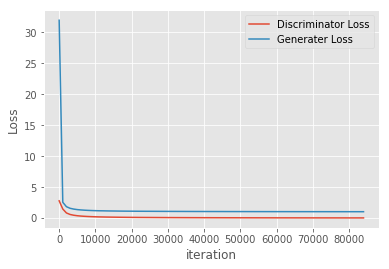

In [10]:
############################
# 結果の表示
############################

print("Discriminator's variance is",variance(list(map(float, D_loss))))
print("Generater's variance is",variance(list(map(float, G_loss))))
print("Discriminator's stdev is",stdev(list(map(float, D_loss))))
print("Generater's stdev is",stdev(list(map(float, G_loss))))

x_num = list(map(lambda x: x*1000, np.arange(0,len(D_mean))))
#print(x_num)
matplotlib.style.use('ggplot')
fig1, Dx = plt.subplots()
Dx.set_xlabel('iteration')
Dx.set_ylabel('Loss')
Dx.plot(x_num,D_mean,label='Discriminator Loss')
Dx.plot(x_num,G_mean,label='Generater Loss')
Dx.legend(loc = 'best')
Dx.set_title('')

plt.xticks(np.arange(0, 84000 + 1, 10000))
plt.title('')

plt.show

In [11]:
fig1.savefig('iterAdam&Tanh&LeakyDGLosses.png')